In [1]:
from Tkinter import Tk
from tkinter.filedialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file

ModuleNotFoundError: No module named 'Tkinter'

In [4]:
%config IPCompleter.greedy=True

In [1]:
import pandas as pd
import numpy as np

In [2]:
event_preds = pd.read_csv('C:/Users/Martin/Desktop/Thesis2/Geopolitics of repressions/Geopolitics-of-Repressions2/Geopolitics-of-Repressions/data/events_predictions.csv')
event_preds["full_name"] = event_preds["name"] + " " + event_preds["patronimic"] + " " + event_preds["surname"]

In [3]:
event_preds.head(5)

,person_id,id,ethnicity,surname,name,patronimic,prediction,full_name
0,1,1,Kalmyk,Авганов,Эрдни,Болдырович,0,Эрдни Болдырович Авганов
1,2,1,Kalmyk,Агальчанова,Соня,Батнасуновна,0,Соня Батнасуновна Агальчанова
2,3,1,Kalmyk,Аджагулов,Цага,Аджагулович,0,Цага Аджагулович Аджагулов
3,4,1,Kalmyk,Аджигиров,Мухла,Манджиевич,0,Мухла Манджиевич Аджигиров
4,5,1,Kalmyk,Адучаева,Пелагея,Чанкишеевна,0,Пелагея Чанкишеевна Адучаева


In [3]:
event_preds.ethnicity = event_preds.ethnicity.astype('category')
y = event_preds.ethnicity.cat.codes


In [6]:
maxlen = 50
training_samples = 750000
validation_samples = 250000
embedding_dim = 100
NGRAMS = 2
#SAMPLE = 1000000
EPOCHS = 15
batch_size = 32
feature_len = 30


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
a = vect.fit_transform(event_preds.full_name)
vocab = vect.vocabulary_



In [8]:
# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)


def find_ngrams(text, n):
    a = zip(*[text[i:] for i in range(n)])
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(event_preds.full_name.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
#y = np.array(sdf.race.astype('category').cat.codes)


num_words = 2235
Max feature len = 74, Avg. feature len = 23


In [28]:
#words

In [9]:
from sklearn.model_selection import train_test_split

X_train,  X_test, y_train, y_test = train_test_split(X[event_preds["prediction"] == 0],
                                                     y[event_preds["prediction"] == 0],
                                                     test_size=0.2, random_state=21,
                                                     stratify=y[event_preds["prediction"] == 0])


In [10]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

print('Pad sequences (samples x time)')
X_train = pad_sequences(X_train, maxlen=feature_len)
X_test = pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


Pad sequences (samples x time)
X_train shape: (947547, 30)
X_test shape: (236887, 30)
38 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (947547, 38)
y_test shape: (236887, 38)


In [6]:
train_data = event_preds[event_preds["prediction"] == 0]

In [7]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(char_level=True)


Using TensorFlow backend.


In [8]:
tokenizer.fit_on_texts(train_data["name"])
sequences = tokenizer.texts_to_sequences(train_data["name"])


In [9]:
char_number = len(tokenizer.word_counts) + 1
print(len(tokenizer.word_counts))
print(tokenizer.document_count)
#print(tokenizer.word_index)
#print(tokenizer.word_docs)
len(train_data["ethnicity"].unique())
labels[:3]

51
1184434


NameError: name 'labels' is not defined

In [10]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical


data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(train_data["ethnicity_cat"])
labels = to_categorical(labels) 


print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices) 
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples] 
y_train = labels[:training_samples] 
x_val = data[training_samples: training_samples + validation_samples] 
y_val = labels[training_samples: training_samples + validation_samples]

Shape of data tensor: (1184434, 50)
Shape of label tensor: (1184434, 38)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM
model = Sequential()
model.add(Embedding(char_number, embedding_dim, input_length=maxlen)) 
model.add(Flatten()) 
model.add(Dense(32, activation='relu'))
model.add(Dense(38, activation='softmax')) 
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           5200      
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                160032    
_________________________________________________________________
dense_3 (Dense)              (None, 38)                1254      
Total params: 166,486
Trainable params: 166,486
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, epochs=2, batch_size=32, validation_data=(x_val, y_val))


Train on 750000 samples, validate on 250000 samples
Epoch 1/2
750000/750000 [==============================] - 109s 145us/sample - loss: 1.5765 - accuracy: 0.6115 - val_loss: 1.5830 - val_accuracy: 0.6142
Epoch 2/2
750000/750000 [==============================] - 112s 150us/sample - loss: 1.6639 - accuracy: 0.6044 - val_loss: 1.6796 - val_accuracy: 0.6040


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM

model = Sequential()
model.add(Embedding(num_words, 32, input_length=feature_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(38, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            71520     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 38)                4902      
Total params: 158,854
Trainable params: 158,854
Non-trainable params: 0
_________________________________________________________________


In [16]:
print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, epochs=5,
          validation_split=0.1)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)


W0805 14:52:15.141376  7416 deprecation.py:323] From C:\Users\Martin\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train...
Train on 852792 samples, validate on 94755 samples
Epoch 1/5
852792/852792 [==============================] - 1289s 2ms/sample - loss: 0.9361 - accuracy: 0.7374 - val_loss: 0.8073 - val_accuracy: 0.7702
Epoch 2/5
852792/852792 [==============================] - 1244s 1ms/sample - loss: 0.7941 - accuracy: 0.7729 - val_loss: 0.7591 - val_accuracy: 0.7818
Epoch 3/5
852792/852792 [==============================] - 1207s 1ms/sample - loss: 0.7648 - accuracy: 0.7801 - val_loss: 0.7427 - val_accuracy: 0.7867
Epoch 4/5
852792/852792 [==============================] - 1310s 2ms/sample - loss: 0.7501 - accuracy: 0.7838 - val_loss: 0.7278 - val_accuracy: 0.7906
Epoch 5/5
236887/236887 [==============================] - 135s 571us/sample - loss: 0.7165 - accuracy: 0.7907
Test score: 0.7164532370643955
Test accuracy: 0.79071033


In [17]:
from sklearn.metrics import classification_report,confusion_matrix

y_pred = model.predict_classes(X_test, verbose=2)
target_names = list(event_preds.ethnicity.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))


236887/236887 - 104s


C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       Altai       0.81      0.19      0.31       403
    Armenian       0.86      0.72      0.78       675
      Balkar       0.92      0.96      0.94      9995
     Bashkir       0.74      0.05      0.09      1694
 Belorussian       0.51      0.33      0.40     14600
   Bulgarian       0.67      0.01      0.02       206
      Buryat       0.84      0.71      0.77      1138
     Chechen       0.80      0.02      0.04       191
     Chinese       0.94      0.90      0.92      1954
     Chuvash       0.80      0.00      0.00      1798
    Estonian       0.68      0.49      0.57      1904
     Finnish       0.87      0.75      0.81      1822
    Georgian       0.89      0.81      0.85       343
      German       0.81      0.88      0.84     15743
       Greek       0.87      0.55      0.67       665
   Hungarian       1.00      0.02      0.04       205
    Japanese       0.89      0.95      0.92       246
      Jewish       0.90    

In [19]:
confusion_matrix(np.argmax(y_test, axis=1), y_pred)

array([[  78,    0,   13, ...,    2,    0,    0],
       [   0,  483,    7, ...,    2,    0,    0],
       [   0,    3, 9623, ...,    0,    0,    0],
       ...,
       [   0,    9,    0, ..., 5669,    0,    0],
       [   0,    0,    2, ...,    0,    9,    0],
       [   0,    0,    0, ...,    0,    0,    6]], dtype=int64)

In [20]:
model.save('C:/Users/Martin/Desktop/Thesis2/Geopolitics of repressions/ethnicity_pred_lstm_model.h5')

In [21]:
words_df = pd.DataFrame(words_list, columns=['vocab'])
words_df.to_csv('C:/Users/Martin/Desktop/Thesis2/Geopolitics of repressions/lstm_model_vocab.csv', index=False, encoding='utf-8')

In [3]:
from tensorflow.keras.models import load_model
model = load_model('C:/Users/Martin/Desktop/Thesis2/Geopolitics of repressions/ethnicity_pred_lstm_model.h5')

W0808 21:21:45.508084  1844 deprecation.py:323] From C:\Users\Martin\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
probs = model.predict_proba(X_test) # to predict probability

https://arxiv.org/pdf/1706.04599.pdf

In [44]:
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

cal_list = list()

for i in range(y_test.shape[1]):
    (prob_true, prob_pred) = calibration_curve(y_test[:, i], probs[:, i], n_bins=10, normalize=True)
    cal_list.append((prob_true, prob_pred)) 
    ir = IsotonicRegression(out_of_bounds='clip').fit(probs[:, i], y_test[:, i])


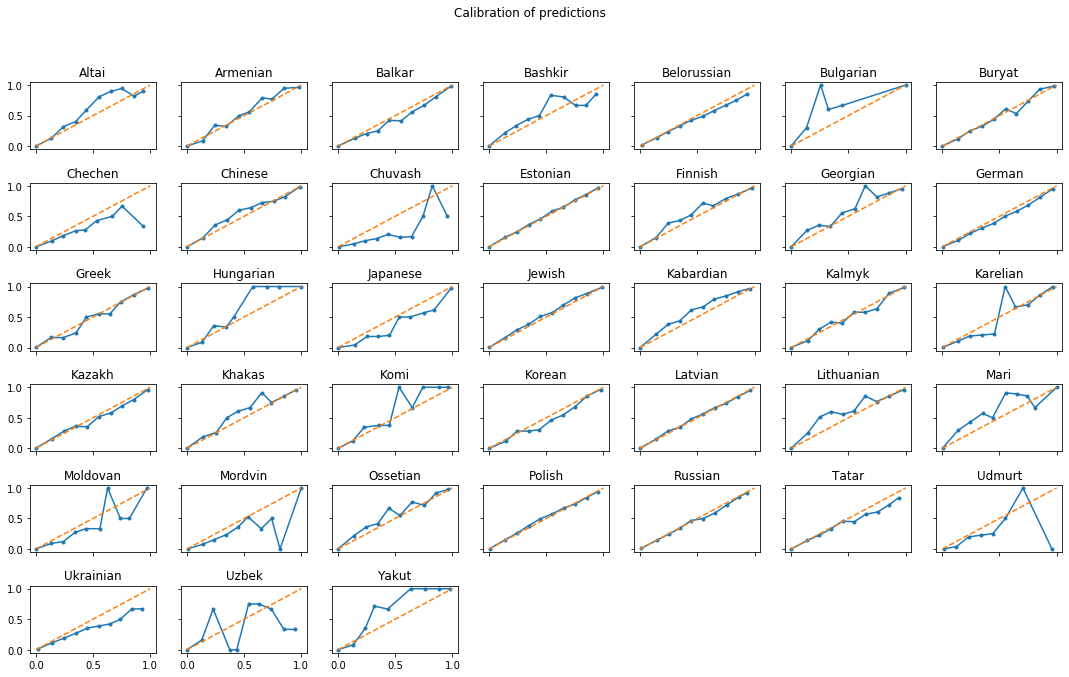

In [64]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=6, ncols=7)
fig.set_size_inches(18.5, 10.5, forward=True)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Calibration of predictions')

target_names = list(event_preds.ethnicity.astype('category').cat.categories)

for ax, data_var, ethn_names in zip(axes.flatten(), cal_list, target_names):
    ax.plot(data_var[1], data_var[0], marker='.')
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.label_outer()
    ax.set(title=ethn_names)

fig.delaxes(axes[5][6])
fig.delaxes(axes[5][5])
axes[5,4].set_axis_off()
axes[5,3].set_axis_off()
    

In [ ]:
from sklearn.isotonic import IsotonicRegression


## Naive Bayes

In [4]:
X = event_preds[["surname", "name", "patronimic"]]
X = event_preds["full_name"]

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer() #make object of Count Vectorizer

vectorizer.fit_transform(X["full_name"])
#X_word_counts #to see count given to words

#vectorizer.vocabulary_
#X.toarray()


<2691643x464610 sparse matrix of type '<class 'numpy.int64'>'
	with 8129380 stored elements in Compressed Sparse Row format>

In [26]:
#vectorizer.vocabulary_[1:2]
print(list(vectorizer.vocabulary_.keys())[1:5])   
vectorizer

['болдырович', 'авганов', 'соня', 'батнасуновна']


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [5]:
from sklearn.model_selection import train_test_split

X_train,  X_test, y_train, y_test = train_test_split(X[event_preds["prediction"] == 0],
                                                     y[event_preds["prediction"] == 0],
                                                     test_size=0.2, random_state=22,
                                                     stratify=y[event_preds["prediction"] == 0])


In [6]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.calibration import CalibratedClassifierCV


model = make_pipeline(CountVectorizer(), MultinomialNB(alpha=0.005))
model_cal = make_pipeline(CountVectorizer(), CalibratedClassifierCV(MultinomialNB(alpha=0.005) ,method='isotonic',cv=5))

In [61]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test) # to predict probability

#### Calibrated model

In [67]:
model_cal.fit(X_train, y_train)
y_pred_cal = model_cal.predict(X_test)
probs_cal = model_cal.predict_proba(X_test) 

In [10]:
from sklearn.metrics import classification_report,confusion_matrix

target_names = list(event_preds.ethnicity.astype('category').cat.categories)
print(classification_report(y_test, y_pred, target_names=target_names))


              precision    recall  f1-score   support

       Altai       0.79      0.40      0.53       403
    Armenian       0.91      0.77      0.84       675
      Balkar       0.97      0.98      0.97      9995
     Bashkir       0.57      0.42      0.48      1694
 Belorussian       0.60      0.47      0.53     14600
   Bulgarian       0.75      0.33      0.45       206
      Buryat       0.92      0.77      0.84      1138
     Chechen       0.70      0.37      0.49       191
     Chinese       0.93      0.94      0.93      1954
     Chuvash       0.46      0.07      0.12      1798
    Estonian       0.78      0.63      0.70      1904
     Finnish       0.91      0.75      0.82      1822
    Georgian       0.85      0.53      0.65       343
      German       0.84      0.89      0.86     15743
       Greek       0.74      0.62      0.68       665
   Hungarian       0.56      0.24      0.34       205
    Japanese       0.97      0.68      0.80       246
      Jewish       0.93    

In [68]:
print(classification_report(y_test, y_pred_cal, target_names=target_names))

              precision    recall  f1-score   support

       Altai       0.85      0.38      0.53       403
    Armenian       0.94      0.76      0.84       675
      Balkar       0.96      0.98      0.97      9995
     Bashkir       0.67      0.33      0.44      1694
 Belorussian       0.65      0.41      0.50     14600
   Bulgarian       0.89      0.29      0.43       206
      Buryat       0.94      0.77      0.84      1138
     Chechen       0.82      0.30      0.44       191
     Chinese       0.95      0.94      0.94      1954
     Chuvash       0.71      0.05      0.10      1798
    Estonian       0.82      0.61      0.70      1904
     Finnish       0.93      0.74      0.82      1822
    Georgian       0.95      0.49      0.64       343
      German       0.89      0.87      0.88     15743
       Greek       0.89      0.57      0.69       665
   Hungarian       0.77      0.20      0.31       205
    Japanese       0.99      0.67      0.80       246
      Jewish       0.93    

In [37]:
from keras.utils.np_utils import to_categorical

y_test_cat = to_categorical(y_test) 

In [59]:
y_prob = probs[:, np.array((y_test- 1).to_list())]
y_test- 1

MemoryError: 

In [56]:
y_test.to_list() 

[32,
 4,
 32,
 4,
 32,
 3,
 32,
 31,
 31,
 4,
 32,
 33,
 32,
 32,
 35,
 32,
 32,
 31,
 8,
 21,
 33,
 31,
 35,
 32,
 32,
 32,
 29,
 32,
 17,
 9,
 32,
 32,
 31,
 32,
 32,
 32,
 17,
 9,
 32,
 32,
 17,
 25,
 32,
 1,
 4,
 35,
 32,
 13,
 31,
 4,
 35,
 4,
 13,
 32,
 2,
 32,
 32,
 33,
 21,
 32,
 32,
 2,
 2,
 32,
 32,
 31,
 24,
 32,
 2,
 13,
 0,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 21,
 32,
 32,
 32,
 13,
 31,
 32,
 32,
 32,
 13,
 35,
 32,
 32,
 32,
 24,
 32,
 32,
 4,
 32,
 31,
 32,
 32,
 24,
 4,
 31,
 21,
 32,
 32,
 31,
 32,
 35,
 26,
 32,
 32,
 32,
 32,
 25,
 32,
 17,
 32,
 32,
 27,
 31,
 32,
 21,
 32,
 13,
 32,
 31,
 32,
 32,
 32,
 31,
 13,
 2,
 2,
 32,
 2,
 32,
 32,
 32,
 31,
 13,
 13,
 3,
 32,
 31,
 32,
 2,
 32,
 4,
 32,
 17,
 33,
 10,
 18,
 21,
 35,
 32,
 32,
 32,
 35,
 32,
 25,
 32,
 35,
 32,
 6,
 32,
 32,
 32,
 35,
 32,
 32,
 10,
 32,
 31,
 31,
 32,
 31,
 32,
 18,
 35,
 2,
 32,
 32,
 13,
 32,
 23,
 32,
 32,
 32,
 17,
 32,
 2,
 32,
 31,
 32,
 32,
 4,
 21,
 17,
 4,
 32,
 32,
 32,
 32,

In [49]:
print(y_test_cat.shape)
y_prob = np.empty([y_test_cat.shape[0], 1])
for i in range(y_test_cat.shape[0]):
    y_prob[i] = probs[i, y_test.to_list()[i]]
    

(236887, 38)


KeyboardInterrupt: 

In [30]:
from sklearn.metrics import brier_score_loss
brier_score_loss(np.array(y_test), np.argmax(a, axis=1)(probs))

ValueError: bad input shape (236887, 38)

In [69]:
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression

cal_list = list()
noncal_list = list()

for i in range(probs.shape[1]):
    (prob_true, prob_pred) = calibration_curve(y_test_cat[:, i], probs_cal[:, i], n_bins=10, normalize=True)
    cal_list.append((prob_true, prob_pred)) 
    (prob_true, prob_pred) = calibration_curve(y_test_cat[:, i], probs[:, i], n_bins=10, normalize=True)
    noncal_list.append((prob_true, prob_pred)) 


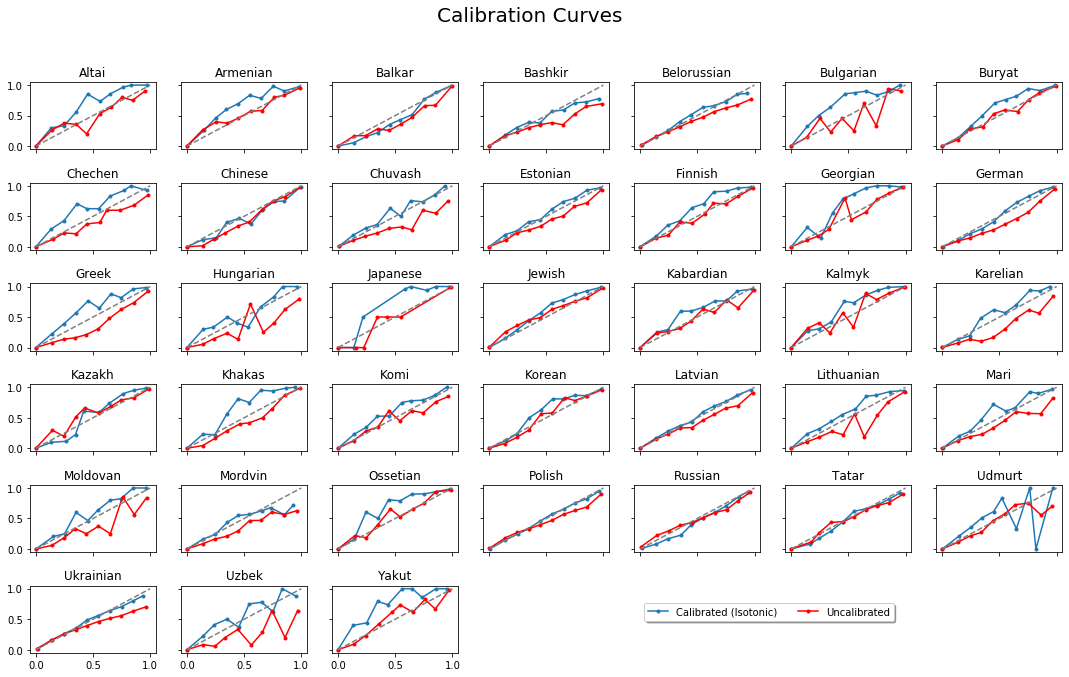

In [70]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=6, ncols=7)
fig.set_size_inches(18.5, 10.5, forward=True)
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Calibration Curves', fontsize=20)

target_names = list(event_preds.ethnicity.astype('category').cat.categories)

for ax, data_var, data_var_noncal, ethn_names in zip(axes.flatten(), cal_list, noncal_list, target_names):
    ax.plot(data_var[1], data_var[0], marker='.', label='Calibrated (Isotonic)')
    ax.plot(data_var_noncal[1], data_var_noncal[0], marker='.', color='red', label='Uncalibrated')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.label_outer()
    ax.set(title=ethn_names)

fig.delaxes(axes[5][6])
fig.delaxes(axes[5][5])
axes[5,4].set_axis_off()
axes[5,3].set_axis_off()
#plt.gca().legend()
ax.legend(loc='lower right', bbox_to_anchor=(4.5, 0.4), ncol=3, fancybox=True, shadow=True)
plt.show()

### Fitting the model to full dataset

In [7]:
model_cal.fit(X[event_preds["prediction"] == 0], y[event_preds["prediction"] == 0])
y_pred_cal_final = model_cal.predict(X[event_preds["prediction"] == 1])
probs_cal_final = model_cal.predict_proba(X[event_preds["prediction"] == 1]) 

### Simulating the data

In [13]:
target_names = list(event_preds.ethnicity.astype('category').cat.categories)

def sample_preds(probs_matrix = probs_cal_final, target_vect = target_names):
    sim_pred = np.empty([probs_matrix.shape[0], 1])
    
    for i in range(probs_matrix.shape[0]):
        sim_pred[i, :] = np.random.choice(range(len(target_vect)), size=None, p=probs_matrix[i, ])
        
    return sim_pred 

In [14]:
sim_number = 5

#sim_pred = np.empty([probs_matrix.shape[0], 1])
sim_list = list()

for i in range(sim_number):
    sim_pred_vect = sample_preds()
    sim_list.append(sim_pred_vect)

In [49]:
sims_array = np.concatenate(sim_list, axis=1 )

In [43]:
sims_df = pd.DataFrame(sims_array, columns=["pred_1", "pred_2", "pred_3", "pred_4", "pred_5"])

In [44]:
for pred_col in ["pred_1", "pred_2", "pred_3", "pred_4", "pred_5"]:
    sims_df[pred_col] = pd.Series(pd.Categorical.from_codes(sims_df[pred_col], categories=target_names))

C:\Users\Martin\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: float codes will be disallowed in the future and raise a ValueError
  


In [45]:
sims_df = pd.concat([event_preds[event_preds["prediction"] == 1]\
                     [["person_id", "ethnicity", "prediction"]].reset_index(drop=True), sims_df],
                    axis=1)

In [48]:
final_dataset = pd.merge(event_preds[["person_id", "ethnicity", "prediction"]], sims_df,
                         on=["person_id", "ethnicity", "prediction"], how='left') 
final_dataset.to_csv("C:/Users/Martin/Desktop/Thesis2/Geopolitics of repressions/Geopolitics-of-Repressions-updated/Geopolitics-of-Repressions-updated/data/events_simulated_predictions.csv",
                    index=False)